In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.ticker as plticker
import os, time
from skimage import io
from skimage.feature import hog
from sklearn import svm
from sklearn import metrics
import pickle

In [16]:
plt.rcParams['figure.figsize'] = (15,15)
plt.rcParams.update({'font.size': 12})

In [2]:
DIR = 'Individual_Component'
SEED = 42

# [HOG parameters]
# img (w,h): (64,80)
# NFEATURES = nblocks * norientations/cell * ncells/block
CELL_PIXELSHAPE = (8,8)
NORIENTATIONS = 12
CELLS_PER_BLOCK = (1,1)

# [SVM parameters/storage]
SVM_MODEL = 'svm_model.pickle'
PRE_TRAINING_IMGS = 'training_preproc_imgs.pickle'
PRE_TESTING_IMGS =   'testing_preproc_imgs.pickle'

0.253s runtime: Individual_Component\train\train_positive_A\00000000\item_00000000.pnm
HOG descriptor size: (960,)


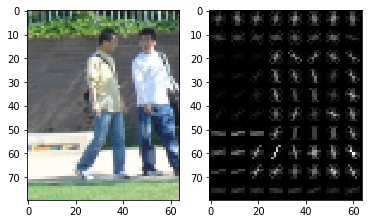

In [3]:
def list_mul(l, num):
    return tuple(map(lambda x: int(num * x), l))

# Histogram of Oriented Gradients
def run_hog(img, visualize=False):
    result = hog(img, orientations=NORIENTATIONS, 
                 pixels_per_cell=CELL_PIXELSHAPE, cells_per_block=CELLS_PER_BLOCK, 
                 block_norm='L2', visualize=visualize, multichannel=True)
    return result

# HOG Performance Evaluation
DEMO = True
if DEMO:
    fn = 'item_00000000.pnm'
    fp = os.path.join(DIR,'train','train_positive_A','00000000',fn)
    start_time = time.time()
    img = io.imread(fp)
    # (compute cell size): #cell_pixelshape = list_mul(img.shape[:2], 1/DIVISOR_NCELLS)
    # hog feature descriptors
    hog_fd, hog_img = run_hog(img, True)
    print('{:.3f}s runtime: {}'.format(time.time() - start_time,fp))
    print('HOG descriptor size:', hog_fd.shape)
    # display results
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.subplot(1,2,2)
    plt.imshow(hog_img, cmap=plt.get_cmap('gray'))

    # ax = plt.gca();    # plot grid lines
    # ax.grid(color='w', linestyle='-', linewidth=2)

In [6]:
# Code to load the dataset
def get_dataset_fp(is_train):
    if is_train:
        subroot = 'train'
    else:
        subroot = 'test'
    base_fp = os.path.join(DIR, subroot)
    pos_dirs = []
    neg_dirs = []
    for dir_name in os.listdir(base_fp): # all files & dirs
        subfp = os.path.join(base_fp, dir_name)
        if not os.path.isdir(subfp):
            continue    
        for subdir_name in os.listdir(subfp):
            subsubfp = os.path.join(subfp, subdir_name)
            if not os.path.isdir(subsubfp):
                continue
            if 'positive' in dir_name:
                pos_dirs.append(subsubfp)
            elif 'negative' in dir_name:
                neg_dirs.append(subsubfp)
    return pos_dirs, neg_dirs

def get_subset_images(fp, nimgs=None, preproc=False):
    results = []
    results_fp = []
    count = 0
    for img_fn in os.listdir(fp):
        img_fp = os.path.join(fp, img_fn)
        if os.path.isdir(img_fp) or img_fn[-4:].lower() != '.pnm':
            continue
        img = io.imread(img_fp)
        if preproc: # proprocess as HOG
            hog_fd = run_hog(img)
            results.append(hog_fd)
        else:
            results.append(img)
        results_fp.append(img_fp)
        count += 1 # restrict num imgs loaded
        if nimgs != None and count >= nimgs:
            break
    return results, results_fp

NO_PERSON = 0
IS_PERSON = 1

def load_images(is_train, shuffle, npos_imgs=None, nneg_imgs=None, save_fn=None):
    print('\n[Loading Images]:')
    pos_dirs, neg_dirs = get_dataset_fp(is_train=is_train)    
    x_train = []
    y_train = []
    fp_train = []
    # get preprocessed training/testing data
    for fp in pos_dirs:
        start_time = time.time()
        cur_subset, cur_subset_fp = get_subset_images(fp, npos_imgs, True)
        x_train += cur_subset
        fp_train += cur_subset_fp
        print('{:.3f}s runtime: {}'.format(time.time() - start_time,fp))
        if npos_imgs != None:
            npos_imgs -= len(cur_subset)
            if npos_imgs <= 0:
                break
    pos_length = len(x_train)
    y_train += [IS_PERSON] * pos_length
    
    for fp in neg_dirs:
        start_time = time.time()
        cur_subset, cur_subset_fp = get_subset_images(fp, nneg_imgs, True)
        x_train += cur_subset
        fp_train += cur_subset_fp
        print('{:.3f}s runtime: {}'.format(time.time() - start_time,fp))
        if nneg_imgs != None:
            nneg_imgs -= len(cur_subset)
            if nneg_imgs <= 0:
                break
    y_train += [NO_PERSON] * (len(x_train) - pos_length)
    
    # shuffle training data
    print('Reformatting data...')
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    fp_train_index = np.arange(len(fp_train)) # create unique IDs (from 0)
    
    if shuffle:
        y_train = y_train.reshape(len(y_train),1)
        fp_train_index = fp_train_index.reshape(len(fp_train_index),1)
        
        data_frame = np.hstack((x_train,y_train, fp_train_index))
        print('Reshuffling data...')
        start_time = time.time()
        np.random.seed(SEED)
        np.random.shuffle(data_frame)
        x_train = data_frame[:,:-2]
        y_train = data_frame[:,-2].ravel()
        fp_train_index = data_frame[:,-1].ravel()
        print('{:.3f}s runtime: shuffling'.format(time.time() - start_time))
    
    result = (x_train, y_train, fp_train_index, fp_train)
    # save loaded images
    if save_fn != None:
        with open(save_fn, 'wb') as fh:
            pickle.dump(result, fh)
    return result
    
# Code to generate the SVM model
def gen_model(model_fn, x_train, y_train):
    # generate SVM model
    print('\n[Training SVM model]:')
    start_time = time.time()
    clf = svm.SVC(probability=True)
    clf.fit(x_train, y_train)
    print('{:.3f}s runtime: training'.format(time.time() - start_time))
    
    # save SVM model
    with open(model_fn, 'wb') as fh:
        pickle.dump(clf, fh)
    return clf

In [7]:
# Generate SVM model (and training images) or load cached result
cur_dir_contents = os.listdir('.')
if SVM_MODEL not in cur_dir_contents:
    x_train, y_train, fp_train_index, fp_train = load_images(True,True, 3000,3000, PRE_TRAINING_IMGS)
    clf = gen_model(SVM_MODEL,x_train,y_train)
    print('Images loaded:', len(x_train))
else:
    with open(SVM_MODEL, 'rb') as fh:
        print('\n[Loading cached SVM model]')
        clf = pickle.load(fh)
    
    if PRE_TRAINING_IMGS != None:
        with open(PRE_TRAINING_IMGS, 'rb') as fh:
            print('[Loading cached training images]')
            x_train, y_train, fp_train_index, fp_train = pickle.load(fh)


[Loading Images]:
8.642s runtime: Individual_Component\train\train_positive_A\00000000
8.521s runtime: Individual_Component\train\train_positive_A\00000001
7.700s runtime: Individual_Component\train\train_positive_A\00000002
7.860s runtime: Individual_Component\train\train_negative_A\00000000
7.868s runtime: Individual_Component\train\train_negative_A\00000001
8.141s runtime: Individual_Component\train\train_negative_A\00000002
Reformatting data...
Reshuffling data...
0.025s runtime: shuffling

[Training SVM model]:


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


117.138s runtime: training
Images loaded: 6000


In [8]:
# Generate test images or load cached result
if PRE_TESTING_IMGS not in cur_dir_contents:
    x_test, y_test, fp_test_index, fp_test = load_images(False,True, save_fn=PRE_TESTING_IMGS)
else:
    with open(PRE_TESTING_IMGS, 'rb') as fh:
        x_test, y_test, fp_test_index, fp_test = pickle.load(fh)

# pos_testdirs, neg_testdirs = get_dataset_fp(is_train=False)
# for fp in pos_testdirs:
#     print('\nTesting subset:', fp)
#     start_time = time.time()
#     x_test = get_subset_images(fp, None, True)
#     y_test = [IS_PERSON] * len(x_test)
#     print('  * {:.3f}s image load time'.format(time.time() - start_time))


[Loading Images]:
2.665s runtime: Individual_Component\test\test_positive\00000000
2.822s runtime: Individual_Component\test\test_positive\00000001
2.590s runtime: Individual_Component\test\test_positive\00000002
1.139s runtime: Individual_Component\test\test_positive\00000003
2.480s runtime: Individual_Component\test\test_negative\00000000
2.636s runtime: Individual_Component\test\test_negative\00000001
2.493s runtime: Individual_Component\test\test_negative\00000002
2.463s runtime: Individual_Component\test\test_negative\00000003
2.519s runtime: Individual_Component\test\test_negative\00000004
2.483s runtime: Individual_Component\test\test_negative\00000005
Reformatting data...
Reshuffling data...
0.036s runtime: shuffling


In [14]:
# Computes statistics for the classifier's performance
def run_test(clf, x_test, y_test):
    print('\n[Evaluating classifier with data]:')
    start_time = time.time()
    y_pred = clf.predict(x_test)
    y_prob = clf.predict_proba(x_test)
    # y_prob: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
    #  - shape: (nsamples, nclasses), by order of `clf.classes_`

    print('  * {:.3f}s prediction time'.format(time.time() - start_time))
    print('  * AUC (weighted): {:.3f}'.format(metrics.roc_auc_score(y_test, y_prob[:,IS_PERSON], average='weighted')))
    print('  * Accuracy: {:.3f}'.format(metrics.accuracy_score(y_test, y_pred)))
    print('  * Recall (weighted): {:.3f}'.format(metrics.recall_score(y_test, y_pred, average='weighted')))
    print('  * Confusion Matrix:')
    print(metrics.confusion_matrix(y_test, y_pred))
    return y_pred, y_prob

# Returns all image file paths detected falsely
def filter_failed_fp(y_pred, y_test, fp_test_index, fp_test):
    failed_fp = []
    for i in range(len(y_pred)):
        if y_pred[i] != y_test[i]:
            if y_pred[i] == NO_PERSON:
                label = 'FN'
            else:
                label = 'FP'
            failed_fp.append( (label, fp_test[int(fp_test_index[i])]) )
    return failed_fp

In [10]:
# Evaluation with provided test images
y_pred, y_prob = run_test(clf, x_test, y_test)


[Evaluating classifier with data]:
  * 31.144s prediction time
  * AUC (weighted): 0.995
  * Accuracy: 0.966
  * Recall (weighted): 0.966
  * Confusion Matrix:
[[5733  267]
 [  51 3406]]


In [11]:
# Sanity check with already consumed training data (should be closer to 100%)
try:
    y_pred_training, y_prob_training = run_test(clf, x_train, y_train)
except NameError as e:
    print('No training data pre-loaded; cannot run this sanity check.')
    #print(e)


[Evaluating classifier with data]:
  * 20.174s prediction time
  * AUC (weighted): 0.995
  * Accuracy: 0.975
  * Recall (weighted): 0.975
  * Confusion Matrix:
[[2886  114]
 [  38 2962]]


In [19]:
# Identify all false results
failed_fp = filter_failed_fp(y_pred, y_test, fp_test_index, fp_test)
nfp = 0
nfn = 0
for label, fp in failed_fp:
    if label == 'FP':
        nfp += 1
    else:
        nfn += 1
    print('{}: {}'.format(label,fp))

FP: Individual_Component\test\test_negative\00000002\item_00002120.pnm
FN: Individual_Component\test\test_positive\00000002\item_00002769.pnm
FN: Individual_Component\test\test_positive\00000001\item_00001790.pnm
FP: Individual_Component\test\test_negative\00000001\item_00001097.pnm
FP: Individual_Component\test\test_negative\00000001\item_00001538.pnm
FP: Individual_Component\test\test_negative\00000001\item_00001236.pnm
FP: Individual_Component\test\test_negative\00000005\item_00005746.pnm
FP: Individual_Component\test\test_negative\00000000\item_00000459.pnm
FP: Individual_Component\test\test_negative\00000001\item_00001661.pnm
FP: Individual_Component\test\test_negative\00000004\item_00004770.pnm
FN: Individual_Component\test\test_positive\00000001\item_00001807.pnm
FP: Individual_Component\test\test_negative\00000005\item_00005238.pnm
FP: Individual_Component\test\test_negative\00000001\item_00001531.pnm
FP: Individual_Component\test\test_negative\00000004\item_00004076.pnm
FP: In

In [20]:
print('FP: {},    FN: {}'.format(nfp,nfn))

FP: 267,    FN: 51
